In [1]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
plt.rcParams.update({
    'figure.figsize': (4.8, 2.7), 'font.size': 15, 'lines.linewidth': 2,
    'xtick.labelsize': 'small', 'ytick.labelsize': 'small',
    'axes.spines.top': False, 'axes.spines.right': False,
    'savefig.dpi': 100,
})

import numpy as np
from pathlib import Path
import os, torch, pickle
from jarvis.utils import tqdm
from hexarena import DATA_DIR, STORE_DIR

FIG_DIR = Path('figures')
os.makedirs(FIG_DIR, exist_ok=True)

rng = np.random.default_rng()

# Gather precomputed belief results

In [2]:
from hexarena.utils import load_monkey_data, align_monkey_data
from compute_beliefs import prepare_blocks, create_model, create_manager
from identify_policies import fetch_beliefs

subject = 'marco'
data_path = DATA_DIR/f'data_{subject}.mat'
block_ids = prepare_blocks(DATA_DIR, subject)
env, model = create_model(subject)

31 valid blocks found.


## Animation of one block

Block 1 of 20211129


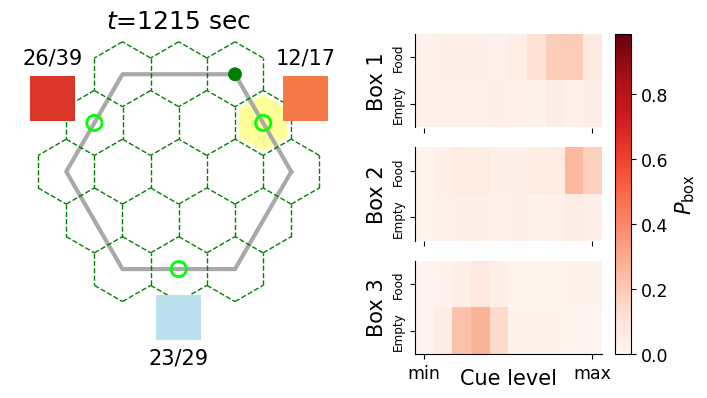

In [3]:
session_id, block_idx = block_ids[0]
print(f'Block {block_idx} of {session_id}')
block_data = load_monkey_data(data_path, session_id, block_idx)
block_data = align_monkey_data(block_data)
env_data = env.convert_experiment_data(block_data)
pos, gaze, colors = env_data['pos'], env_data['gaze'], env_data['colors']
push, success = env_data['push'], env_data['success']
counts = env_data['counts']
rewarded = [None]
for t in range(env_data['num_steps']):
    if push[t]:
        rewarded.append(success[t])
    else:
        rewarded.append(None)
*_, beliefs = fetch_beliefs(DATA_DIR, STORE_DIR, subject, session_id, block_idx)
num_levels = env.boxes[0].num_levels
p_boxes = torch.softmax(
    torch.tensor(beliefs).reshape(-1, 3, 2*num_levels), dim=2,
).reshape(-1, 3, 2, num_levels).numpy()

fig, ani = env.play_episode(
    pos, gaze, rewarded=rewarded, colors=colors, counts=counts, p_boxes=p_boxes, tmin=env_data['num_steps']-240,
)

# HTML(ani.to_jshtml())
savename = f'belief.dynamics_{subject}_[{session_id}-{block_idx}]'
ani.save(FIG_DIR/f'{savename}.mp4', dpi=200)
fig.savefig(FIG_DIR/f'{savename}.svg')

## Split data into training and testing blocks

In [4]:
idxs = np.random.default_rng(0).choice(len(block_ids), len(block_ids), replace=False)
n_train = int(len(idxs)*0.95)
idxs = {'train': idxs[:n_train], 'test': idxs[n_train:]} # divide all blocks into train and test

ts_wait, observations, actions, knowns, beliefs = {}, {}, {}, {}, {}
for tag in ['train', 'test']:
    ts_wait[tag], observations[tag], actions[tag], knowns[tag], beliefs[tag] = [], [], [], [], []
    for i in tqdm(idxs[tag], desc=tag, unit='block', leave=False):
        session_id, block_idx = block_ids[i]
        _observations, _actions, _knowns, _beliefs = fetch_beliefs(DATA_DIR, STORE_DIR, subject, session_id, block_idx)
        T = len(_actions)
        observations[tag].append(_observations[:T])
        actions[tag].append(_actions[:T])
        knowns[tag].append(_knowns[:T])
        beliefs[tag].append(_beliefs[:T])
        
        block_data = load_monkey_data(DATA_DIR/f'data_{subject}.mat', session_id, block_idx)
        block_data = align_monkey_data(block_data)
        env_data = env.convert_experiment_data(block_data)
        ts_wait[tag].append(env_data['t_wait'][:T])
    ts_wait[tag] = np.concatenate(ts_wait[tag])
    observations[tag] = np.concatenate(observations[tag])
    actions[tag] = np.concatenate(actions[tag])
    knowns[tag] = np.concatenate(knowns[tag])
    beliefs[tag] = np.concatenate(beliefs[tag])

train:   0%|                                                                                                  …

test:   0%|                                                                                                   …

In [5]:
from irc.hmp import HiddenMarkovPolicy

vae_dir = STORE_DIR/'belief_vaes'
os.makedirs(vae_dir, exist_ok=True)
kl_losses = {}
for z_dim in tqdm(range(1, 13)):
    hmp = HiddenMarkovPolicy(model.p_s, z_dim, 2, ebd_b=model.ebd_b)
    vae_path = vae_dir/'belief.vae_[Dz{:02d}].pkl'.format(z_dim)
    try:
        with open(vae_path, 'rb') as f:
            saved = pickle.load(f)
        hmp.belief_vae.load_state_dict(saved['state_dict'])
    except:
        stats = hmp.train_belief_vae(
            torch.tensor(beliefs['train']), z_reg=0.01, pbar_kw={'leave': False},
        )
        with open(STORE_DIR/'belief_vaes/belief.vae_[Dz{:02d}].pkl'.format(z_dim), 'wb') as f:
            pickle.dump({
                'state_dict': hmp.belief_vae.state_dict(),
                'stats': stats,
            }, f)
    with torch.no_grad():
        _, _, recons = hmp.belief_vae(torch.tensor(beliefs['test']), n_scale=0.)
    kl_losses[z_dim] = []
    for i in range(len(recons)):
        d, _ = hmp.belief_vae.p_x.kl_divergence(recons[i], torch.tensor(beliefs['test'][i]))
        kl_losses[z_dim].append(d)
    kl_losses[z_dim] = torch.stack(kl_losses[z_dim])

  0%|                                                                                                         …

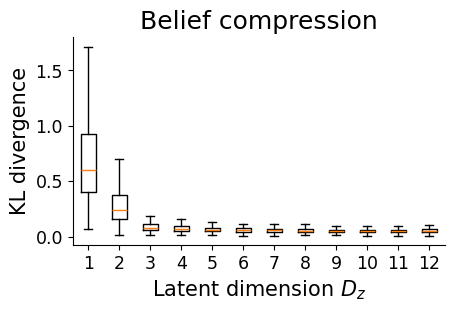

In [6]:
z_dims = np.arange(1, 13)
kls_mean = np.array([kl_losses[z_dim].mean() for z_dim in z_dims])
kls_std = np.array([kl_losses[z_dim].std() for z_dim in z_dims])

fig, ax = plt.subplots()
ax.boxplot(
    [kl_losses[z_dim] for z_dim in z_dims],
    sym='', positions=z_dims,
)
ax.set_xlabel('Latent dimension $D_z$')
ax.set_ylabel('KL divergence')
ax.set_title('Belief compression')
fig.savefig(FIG_DIR/f'belief.compression_{subject}.svg')

## Visualize belief in 3-D latent space

### Coloring by time since last push

In [7]:
from identify_policies import init_hmp

z_dim, num_macros = 3, 10
policy = {'num_features': [], 'nonlinearity': 'Softplus'}
hmp = init_hmp(model, z_dim, num_macros, 1, policy, STORE_DIR)
zs = hmp.compress_beliefs(torch.tensor(beliefs['train'])).numpy()
ts_boxes = np.log(ts_wait['train']+0.5)
ts_boxes += rng.normal(scale=0.0001, size=ts_boxes.shape) # break symmetry

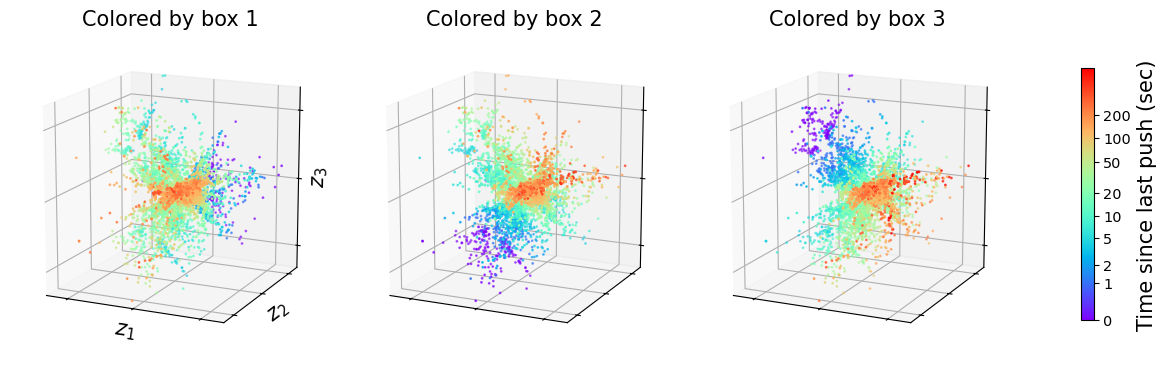

In [8]:
fig = plt.figure(figsize=(14, 4))
idxs = rng.choice(len(zs), 5000)
cmin, cmax = ts_boxes[idxs].min(), ts_boxes[idxs].max()
margin, gap = 0.05, 0.02
width = (1-2*margin-2*gap)/3
axes, artists = [], []
for i in range(3):
    ax = fig.add_axes([margin+(width+gap)*i, 0.05, width, 0.9], projection='3d', elev=15)
    artists.append(ax.scatter(
        zs[idxs, 0], zs[idxs, 1], zs[idxs, 2], s=1,
        c=ts_boxes[idxs, i], cmap='rainbow', vmin=cmin, vmax=cmax,
    ))
    ax_lim = [-4, 4]
    ax.set_xlim(ax_lim), ax.set_ylim(ax_lim), ax.set_zlim(ax_lim)
    ax.set_aspect('equal')
    ax_ticks = [-3, 0, 3]
    ax.set_xticks(ax_ticks), ax.set_yticks(ax_ticks), ax.set_zticks(ax_ticks)
    ax.set_xticklabels([]), ax.set_yticklabels([]), ax.set_zticklabels([])
    if i==0:
        ax.set_xlabel('$z_1$', labelpad=-10), ax.set_ylabel('$z_2$', labelpad=-10), ax.set_zlabel('$z_3$', labelpad=-10)
    ax.set_title(f'Colored by box {i+1}', fontsize='medium')
    axes.append(ax)
cbar = plt.colorbar(artists[0], ax=axes, shrink=0.7, label='Time since last push (sec)')
ticks = np.array([0, 1, 2, 5, 10, 20, 50, 100, 200])
cbar.ax.set_yticks(np.log(0.5+ticks/env.dt))
cbar.ax.set_yticklabels(['{:d}'.format(x) for x in ticks], fontsize='x-small')

def update(t, total=36):
    az = (t/total)*360-60
    for ax in axes:
        ax.view_init(azim=az)
    return artists

total = 72
ani = FuncAnimation(
    fig, update, fargs=(total,), frames=range(total), blit=True,
)

# HTML(ani.to_jshtml())
savename = f'colored.belief.space_{subject}'
ani.save(FIG_DIR/f'{savename}.mp4', dpi=200)
fig.savefig(FIG_DIR/f'{savename}.svg')

### Trace in belief space

Block 1 of 20211129


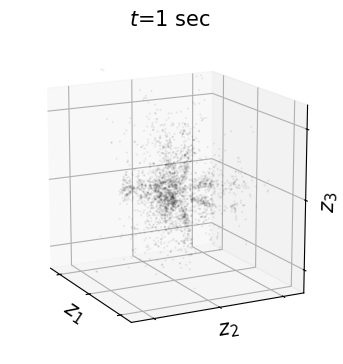

In [9]:
fig = plt.figure(figsize=(4, 4))
ax = fig.add_axes([0.05, 0.05, 0.9, 0.8], projection='3d', elev=15)
idxs = rng.choice(len(zs), 3000)
ax.scatter(zs[idxs, 0], zs[idxs, 1], zs[idxs, 2], s=0.5, c='black', alpha=0.05)
ax.set_xlim(ax_lim), ax.set_ylim(ax_lim), ax.set_zlim(ax_lim)
ax.set_aspect('equal')
ax.set_xticks(ax_ticks), ax.set_yticks(ax_ticks), ax.set_zticks(ax_ticks)
ax.set_xticklabels([]), ax.set_yticklabels([]), ax.set_zticklabels([])
ax.set_xlabel('$z_1$'), ax.set_ylabel('$z_2$'), ax.set_zlabel('$z_3$')
ax.set_xlabel('$z_1$', labelpad=-10), ax.set_ylabel('$z_2$', labelpad=-10), ax.set_zlabel('$z_3$', labelpad=-10)

session_id, block_idx = block_ids[0]
print(f'Block {block_idx} of {session_id}')
*_, beliefs_block = fetch_beliefs(DATA_DIR, STORE_DIR, subject, session_id, block_idx)
zs_block = hmp.compress_beliefs(torch.tensor(beliefs_block))
trace_len = 20
h = ax.scatter(zs_block[:trace_len, 0], zs_block[:trace_len, 1], zs_block[:trace_len, 2], s=20, c=np.arange(trace_len), cmap='Greens')
h_title = ax.set_title('', fontsize='medium')

def update(t):
    az = 2.5*t-30
    ax.view_init(azim=az)
    h.set_offsets(zs_block[t-trace_len:t, :2])
    h.set_3d_properties(zs_block[t-trace_len:t, 2], 'z')
    h_title.set_text(r'$t$='+'{}'.format(
        '{:d} sec'.format(int(np.floor(t*env.dt)))
    ))
    return h, h_title

ani = FuncAnimation(
    fig, update, frames=range(len(beliefs)-240, len(beliefs)), blit=True,
)
# HTML(ani.to_jshtml())
savename = f'belief.trace_{subject}_[{session_id}-{block_idx}]'
ani.save(FIG_DIR/f'{savename}.mp4', dpi=200)
fig.savefig(FIG_DIR/f'{savename}.svg')

## Visualize belief in 2-D space

In [10]:
w, *_ = np.linalg.lstsq(
    np.concatenate([zs, np.ones((len(zs), 1))], axis=1),
    ts_boxes.mean(axis=1), rcond=None,
)
w = w[:3]
w /= (w**2).sum()**0.5
zs_1d = np.matmul(zs, w)

zs_res = zs-zs_1d[:, None]*w
u, s, _ = np.linalg.svd(np.cov(zs_res.T), hermitian=True)
zs_2d = np.matmul(zs_res, u[:, :2])

w_rot = np.concatenate([w[:, None], u[:, :2]], axis=1)
with open('store/belief.proj_3D.pkl', 'wb') as f:
    pickle.dump(w_rot, f)

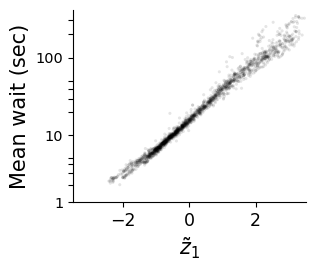

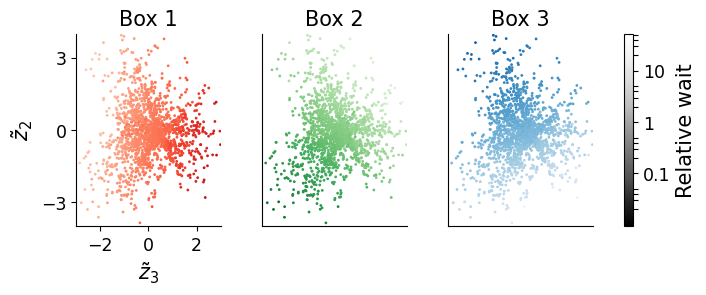

In [11]:
idxs = rng.choice(len(zs), 2000)
fig, ax = plt.subplots(figsize=(3, 2.5))
ax.scatter(zs_1d[idxs], ts_boxes[idxs].mean(axis=1), s=5, edgecolor='none', facecolor='black', alpha=0.1)
ax.set_xlim([-3.5, 3.5])
ax.set_ylim([1, 6])
ax.set_xlabel(r'$\tilde{z}_1$')
ax.set_ylabel(r'Mean wait (sec)')
ticks = np.array([1, 2, 3, 4, 5, 10, 20, 30, 40, 50, 100, 200, 300])
ax.set_yticks(np.log(0.5+ticks/env.dt))
ax.set_yticklabels(['{:d}'.format(x) if x==10**int(np.log10(x)) else '' for x in ticks], fontsize='x-small')
fig.savefig(FIG_DIR/f'belief.1d_{subject}.svg')

cmaps = ['Reds_r', 'Greens_r', 'Blues_r']
dts = ts_boxes-ts_boxes.mean(axis=1, keepdims=True)
vmin, vmax = dts.min(), dts.max()
fig, axes = plt.subplots(1, 3, figsize=(8, 2.5))
for i, ax in enumerate(axes):
    ax.scatter(
        zs_2d[idxs, 1], zs_2d[idxs, 0], s=1,
        c=dts[idxs, i], cmap=cmaps[i], vmin=vmin, vmax=vmax
    )
    ax.set_xlim([-3, 3]), ax.set_ylim([-4, 4])
    ax.set_aspect('equal')
    ax.set_title(f'Box {i+1}', fontsize='medium')
cbar = fig.colorbar(
    mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=vmin, vmax=vmax), cmap='Greys_r'), ax=axes,
    fraction=0.1, label='Relative wait',
)
ticks = np.array([0.02, 0.03, 0.04, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 1, 2, 3, 4, 5, 10, 20, 30, 40, 50])
cbar.ax.set_yticks(np.log(ticks))
cbar.ax.set_yticklabels(['{:g}'.format(x) if x==10**int(np.log10(x)) else '' for x in ticks], fontsize='small')
ax = axes[0]
ax.set_xticks([-2, 0, 2]), ax.set_yticks([-3, 0, 3])
ax.set_xlabel(r'$\tilde{z}_3$'), ax.set_ylabel(r'$\tilde{z}_2$')
for ax in axes[1:]:
    ax.set_xticks([]), ax.set_yticks([])
fig.savefig(FIG_DIR/f'belief.2d_{subject}.svg')

# Policy identification using hidden Markov model

In [12]:
from identify_policies import create_manager, fetch_results

num_macros = 10
manager = create_manager(DATA_DIR, STORE_DIR, subject, block_ids, num_macros=num_macros)

Collect data:   0%|                                                                                           …

## Overview of all trained HMM solutions

In [13]:
metrics = {}
k_min, k_max = 1, 7
for num_policies in tqdm(range(k_min, k_max), unit='condition'):
    metrics[num_policies] = []
    for key, config in manager.completed(min_epoch=40, cond={'num_policies': num_policies}):
        manager.setup(config)
        manager.load_ckpt(manager.ckpts[key])

        # ll = manager.lls[-1].item()
        ll = manager.ckpts[key]['ll_test']
        log_pi = manager.hmp.log_pi.clone()
        for _ in range(20):
            log_pi = torch.stack([torch.logsumexp(manager.hmp.log_A[:, i]+log_pi, dim=0) for i in range(manager.hmp.num_policies)])
        ent = -(log_pi.exp()*log_pi).sum().item()
        p_dwell = (manager.hmp.log_A.diag()+log_pi).exp().sum().item()
        if p_dwell>3:
            raise

        metrics[num_policies].append((key, ll, ent, p_dwell))

  0%|                                                                                                         …

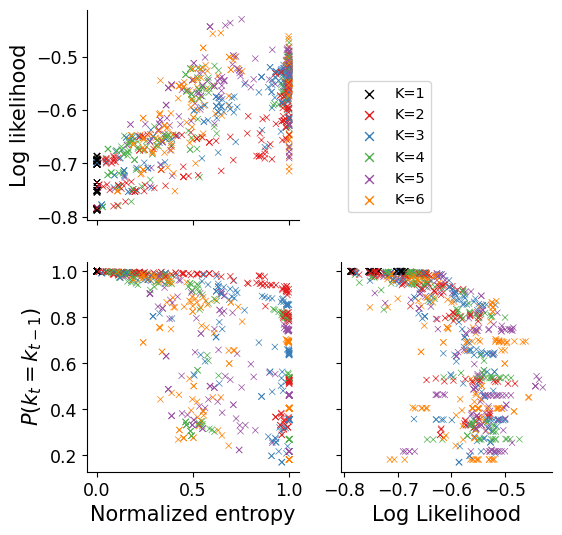

In [14]:
fig, axes = plt.subplots(2, 2, figsize=(6, 6))
palette = np.stack([(0, 0, 0), *mpl.colormaps['Set1'].colors[:5]])
lls, ents, ps_dwell = [], [], []
colors = []
for num_policies in range(k_min, k_max):
    _lls, _ents, _ps_dwell = np.array([(ll, ent, p_dwell) for _, ll, ent, p_dwell in metrics[num_policies]]).T
    if num_policies>1:
        _ents /= np.log(num_policies)
    lls.append(_lls); ents.append(_ents); ps_dwell.append(_ps_dwell)
    colors.append(np.tile(palette[num_policies-1][None], (len(_lls), 1)))
lls = np.concatenate(lls); ents = np.concatenate(ents); ps_dwell = np.concatenate(ps_dwell)
colors = np.concatenate(colors)
idxs = rng.permutation(len(lls))
lls = lls[idxs]; ents = ents[idxs]; ps_dwell = ps_dwell[idxs]; colors = colors[idxs]

for i, ax in enumerate(axes.ravel()):
    if i==0:
        xs = ents; xlabel = ''
        ys = lls; ylabel = 'Log likelihood'
    if i==1:
        continue
    if i==2:
        xs = ents; xlabel = 'Normalized entropy'
        ys = ps_dwell; ylabel = '$P(k_t=k_{t-1})$'
    if i==3:
        xs = lls; xlabel = 'Log Likelihood'
        ys = ps_dwell; ylabel = ''
    ax.scatter(xs, ys, c=colors, marker='x', s=20, linewidth=0.5)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
ax = axes[0, 1]; hs = []
for num_policies in range(k_min, k_max):
    hs.append(ax.scatter([], [], marker='x', s=40, linewidth=1, color=palette[num_policies-1]))
ax.legend(hs, [f'K={k}' for k in range(k_min, k_max)], loc='lower left', fontsize='x-small')
ax.axis('off')
axes[0, 0].set_xticklabels([])
axes[1, 1].set_yticklabels([])
fig.savefig(FIG_DIR/'HMP.comparison.svg')

## Perform clustering for solutions with the same number of policies

In [15]:
keys_cluster = {}

In [18]:
keys_good, lls, ents, ps_dwell = [], [], [], []
num_policies = 3
for key, ll, ent, p_dwell in metrics[num_policies]:
    if ent/np.log(num_policies)>0.8 and p_dwell>0.9**num_policies:
        keys_good.append(key)
        lls.append(ll)
        ents.append(ent)
        ps_dwell.append(p_dwell)
print(f'{len(keys_good)} solutions collected')
keys_good, lls, ents, ps_dwell = list(zip(*sorted(zip(keys_good, lls, ents, ps_dwell), key=lambda x: x[1], reverse=True)))

manager.setup(manager.configs[rng.choice(keys_good)])
inputs = manager.hmp.policy_inputs(torch.cat(manager.knowns), torch.cat(manager.beliefs))

17 solutions collected


In [19]:
from itertools import permutations

def compute_JSdiv(logps_p, logps_q):
    r"""Computes Jensen-Shannon divergence of two sets of policies.

    Args
    ----
    logps_p, logps_q: (num_steps, num_policies, num_macros)
        Action probabilities from two sets of policies.

    Returns
    -------
    jss: (num_steps,)
        JS divergence at each time step, with each policy pair weighted equally.
    
    """
    logps_m = torch.logsumexp(torch.stack([logps_p, logps_q]), dim=0)-np.log(2)
    kls_pm = (logps_p.exp()*(logps_p-logps_m)).sum(dim=2)
    kls_qm = (logps_q.exp()*(logps_q-logps_m)).sum(dim=2)
    jss = ((kls_pm+kls_qm)/2).mean(dim=1).clamp(min=0)
    return jss

def optimal_JSdiv(manager, inputs, key_p, key_q):
    r"""
    Args
    ----
    manager:
        The manager for hidden Markov policies.
    inputs:
        Shared inputs to policy networks.
    key_p, key_q:
        Keys to the two HMM solutions.

    """
    manager.setup(manager.configs[key_p])
    manager.load_ckpt(manager.ckpts[key_p])
    with torch.no_grad():
        _, logps_p = manager.hmp.action_probs(inputs)
    manager.setup(manager.configs[key_q])
    manager.load_ckpt(manager.ckpts[key_q])
    with torch.no_grad():
        _, logps_q = manager.hmp.action_probs(inputs)

    num_policies = logps_p.shape[1]
    jss_min, best_perm = None, None
    for perm in permutations(range(num_policies)):
        jss = compute_JSdiv(logps_p, logps_q[:, perm])
        if jss_min is None or jss.mean()<jss_min.mean():
            jss_min = jss
            best_perm = perm
    return jss_min, best_perm

In [20]:
from itertools import combinations

manager.setup(manager.configs[rng.choice(keys_good)])
inputs = manager.hmp.policy_inputs(torch.cat(manager.knowns), torch.cat(manager.beliefs))
keys_pq = [sorted((key_p, key_q)) for key_p, key_q in combinations(keys_good, 2)]
jss, perms = {}, {}
for key_p, key_q in tqdm(keys_pq):
    jss_min, best_perm = optimal_JSdiv(manager, inputs, key_p, key_q)
    jss[(key_p, key_q)] = jss_min.mean().item()
    perms[(key_p, key_q)] = best_perm

js_matrix = np.zeros((len(keys_good), len(keys_good)))
for i, key_p in enumerate(keys_good):
    for j, key_q in enumerate(keys_good):
        if key_p<key_q:
            js_matrix[i, j] = js_matrix[j, i] = jss[(key_p, key_q)]

  0%|                                                                                                         …

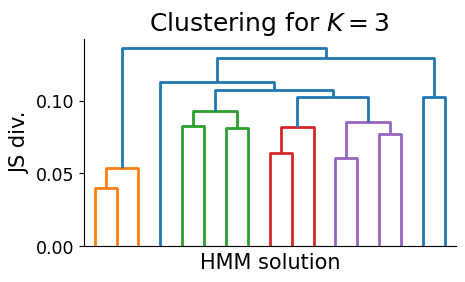

In [21]:
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import linkage, dendrogram

Z = linkage(squareform(js_matrix), method='average', optimal_ordering=True)

fig, ax = plt.subplots()
R = dendrogram(Z, color_threshold=0.1, ax=ax, no_labels=True)
ax.set_xlabel('HMM solution')
ax.set_ylabel('JS div.')
ax.set_title(f'Clustering for $K=${num_policies}')
plt.show()

fig.savefig(FIG_DIR/f'{subject}.policy.dendrogram_{num_policies}.svg')

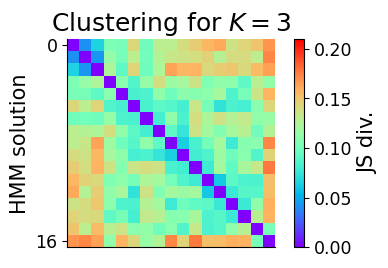

In [22]:
fig, ax = plt.subplots()
h = ax.imshow(js_matrix[R['leaves']][:, R['leaves']], cmap='rainbow', vmin=0, vmax=0.21)
ax.set_title(f'Clustering for $K=${num_policies}')
ax.set_yticks([0, len(js_matrix)-1])
ax.set_xticks([])
ax.set_ylabel('HMM solution')
fig.colorbar(h, label='JS div.')
plt.show()

fig.savefig(FIG_DIR/f'{subject}.policy.JS.div_{num_policies}.svg')

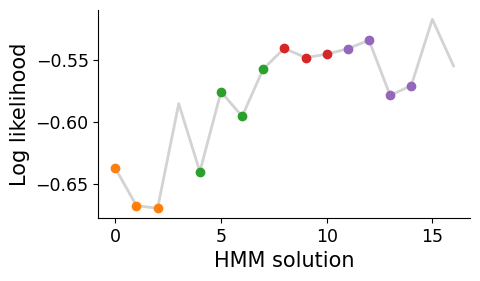

Representative of the biggest cluster: 38E62951


In [23]:
fig, ax = plt.subplots()
ax.plot(np.array(lls)[R['leaves']], color='lightgray', zorder=0)
ax.set_xlabel('HMM solution')
ax.set_ylabel('Log likelihood')

c_labels = np.setdiff1d(R['leaves_color_list'], 'C0')
max_cluster = None
for c_label in c_labels:
    k_idxs, = np.array([c==c_label for c in R['leaves_color_list']], dtype=bool).nonzero()
    if max_cluster is None or len(k_idxs)>len(max_cluster):
        max_cluster = np.array(R['leaves'])[k_idxs]
    if len(k_idxs)<3:
        continue
    ax.scatter(k_idxs, np.array(lls)[R['leaves']][k_idxs], c=c_label)
plt.show()

fig.savefig(FIG_DIR/f'{subject}.policy.likelihood_{num_policies}.svg')

good_key = keys_good[max_cluster[np.argmin(js_matrix[max_cluster][:, max_cluster].mean(axis=1))]]
keys_cluster[num_policies] = [keys_good[i] for i in max_cluster]
print('Representative of the biggest cluster: {}'.format(good_key))

## Compare data log likelihood for different number of policies

# Visualize HMM solution

## HMM iteration

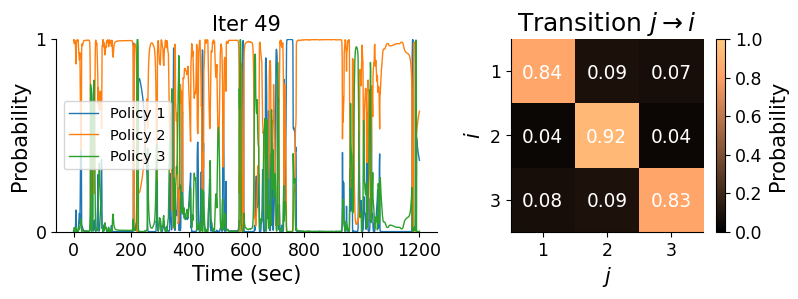

In [31]:
keys_plot = {
    1: '0254D0BA',
    2: 'FBD4D3FE',
    3: '38E62951',
    4: 'D6C9F84E',
    5: 'ED2F643D',
    6: 'C8E5AAA3',
}

num_policies = 3
key = keys_plot[num_policies]

manager.setup(manager.configs[key])
manager.load_ckpt(manager.ckpts[key])

# block_idx = rng.choice(len(block_ids))
block_idx = 4
gammas = torch.stack(manager.gammas[block_idx])
As = torch.stack(manager.As).numpy()
N = num_policies

fig, axes = plt.subplots(1, 2, figsize=(9, 2.5), gridspec_kw={'width_ratios': [1.5, 1]})
ax = axes[0]
h_gammas = ax.plot(gammas[0], linewidth=1)
h_title = ax.set_title('', fontsize='medium')
ax.set_xlabel('Time (sec)')
ax.set_ylabel('Probability')
ax.set_ylim([0, 1])
ax.set_yticks([0, 1])
ax.legend(h_gammas, [f'Policy {i+1}' for i in range(N)], loc='center left', fontsize='x-small')
ax = axes[1]
h_A = ax.imshow(As[0], vmin=0, vmax=1, extent=[0.5, N+0.5, N+0.5, 0.5], cmap='copper')
h_probs = np.empty((N, N), dtype=object)
for i in range(N):
    for j in range(N):
        h_probs[i, j] = ax.text(
            j+1, i+1, '{:.2f}'.format(As[0, i, j]), ha='center', va='center_baseline',
            color='white', fontsize=40/N,
        )
ax.set_xlim([0.5, N+0.5]), ax.set_ylim([N+0.5, 0.5])
ax.set_xticks(np.arange(N)+1), ax.set_yticks(np.arange(N)+1)
ax.set_title(r'Transition $j \rightarrow i$')
ax.set_xlabel('$j$'), ax.set_ylabel('$i$')
plt.colorbar(
    h_A, ax=ax, shrink=1, label='Probability',
)

def update(t):
    for i in range(num_policies):
        h_gammas[i].set_ydata(gammas[t, :, i])
    h_A.set_data(As[t])
    h_title.set_text(f'Iter {t}')
    for i in range(N):
        for j in range(N):
            h_probs[i, j].set_text('{:.2f}'.format(As[t, i, j]))
    return *h_gammas, h_A, h_title, *h_probs.flatten()

ani = FuncAnimation(
    fig, update, frames=range(len(gammas)), blit=False,
)

# HTML(ani.to_jshtml())
savename = 'EM.iteration_{}[block{:02d}]_[Np{}]'.format(subject, block_idx, num_policies)
ani.save(FIG_DIR/f'{savename}.mp4', dpi=200)
fig.savefig(FIG_DIR/f'{savename}.svg')
plt.show()

## Visualizing policies

In [32]:
from identify_policies import e_step

hmp = manager.hmp
knowns = torch.cat(manager.knowns)
beliefs = torch.cat(manager.beliefs)
actions = torch.cat(manager.actions)
log_gammas, _, _ = e_step(manager.hmp, manager.knowns, manager.beliefs, manager.actions)
gammas = torch.cat([log_gammas[i].exp() for i in range(len(log_gammas))]).mean(dim=0)

with torch.no_grad():
    zs = hmp.compress_beliefs(beliefs)
    inputs = hmp.policy_inputs(knowns, beliefs)
    _, logps = hmp.action_probs(inputs)
    deltas = hmp.emission_probs(logps, actions).std(dim=1)

with open('store/belief.proj_3D.pkl', 'rb') as f:
    w_rot = pickle.load(f)
zs = np.matmul(zs, w_rot)

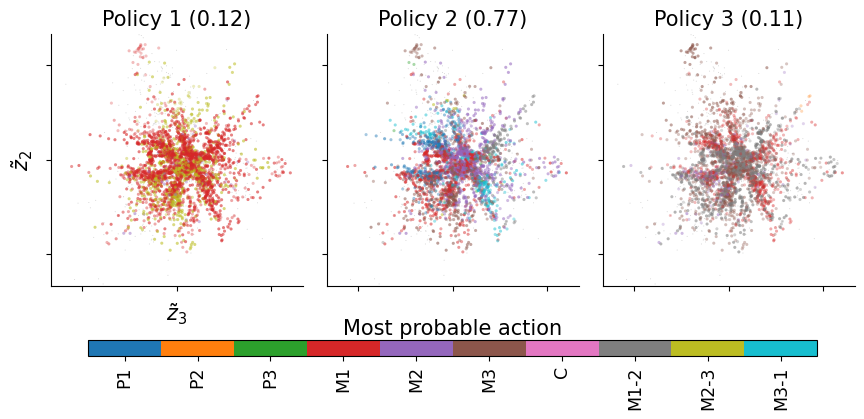

In [33]:
palette = plt.get_cmap('tab10').colors

fig = plt.figure(figsize=(3*num_policies, 4))
assert np.array(palette).shape==(num_macros, 3)
margin, gap = 0.05, 0.02
width = (1-2*margin-2*gap)/num_policies
axes, artists = [], []
c_scale = logps.max().exp()
idxs = np.argsort(deltas.numpy())[-3000:]
rng.shuffle(idxs)
idxs_base = rng.choice(len(zs), 1000)
for k in range(num_policies):
    _, a_idxs = logps[idxs, k].max(dim=1)
    cs = []
    for i, a_idx in enumerate(a_idxs):
        alpha = logps[idxs[i], k, a_idx].exp().item()/c_scale*0.4+0.2
        cs.append((*palette[a_idx], alpha))
    cs = np.array(cs)

    ax = fig.add_axes([margin+(width+gap)*k, 0.05, width, 0.9])
    ax.scatter(zs[idxs_base, 2], zs[idxs_base, 1], s=0.5, c='lightgray', edgecolor='none', zorder=-1)
    ax.scatter(zs[idxs, 2], zs[idxs, 1], s=5, c=cs, edgecolor='none')
    ax_lim = [-4, 4]
    ax.set_xlim(ax_lim), ax.set_ylim(ax_lim)
    ax.set_aspect('equal')
    ax_ticks = [-3, 0, 3]
    ax.set_xticks(ax_ticks), ax.set_yticks(ax_ticks)
    ax.set_xticklabels([]), ax.set_yticklabels([])
    if k==0:
        ax.set_xlabel(r'$\tilde{z}_3$'), ax.set_ylabel(r'$\tilde{z}_2$')
    ax.set_title('Policy {} ({:.2f})'.format(k+1, gammas[k]), fontsize='medium')
    axes.append(ax)
cbar = plt.colorbar(
    mpl.cm.ScalarMappable(cmap='tab10'), ax=axes,
    orientation='horizontal', shrink=.9, aspect=15*num_policies, pad=0.15,
    label='Most probable action',
)
cbar.ax.set_xticks((np.arange(num_macros)+0.5)/num_macros)
cbar.ax.set_xticklabels([
    'P1', 'P2', 'P3', 'M1', 'M2', 'M3', 'C', 'M1-2', 'M2-3', 'M3-1',
], rotation=90)
cbar.ax.xaxis.set_label_position('top')
fig.savefig(FIG_DIR/f'{subject}_policy.on.2d.belief_[{num_policies}policy].svg')

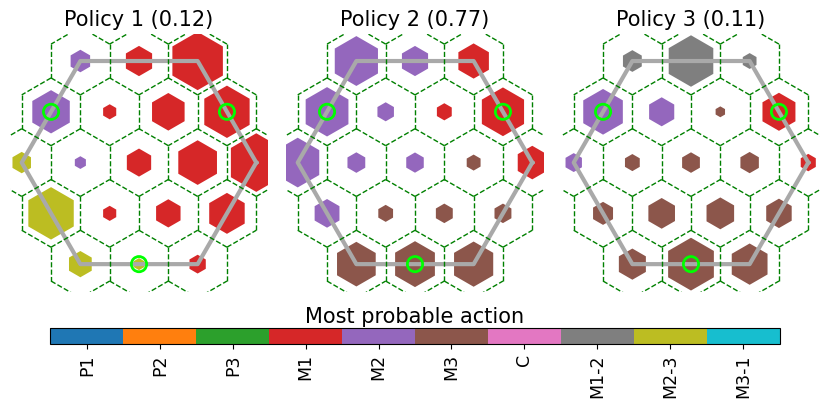

In [34]:
num_tiles = env.arena.num_tiles
probs = np.empty((num_policies, num_tiles, num_macros))
for k in range(num_policies):
    for pos in range(num_tiles):
        idxs = knowns[:, 0].numpy().astype(int)==pos
        probs[k, pos] = logps[idxs, k].exp().mean(dim=0).numpy()

fig = plt.figure(figsize=(3*num_policies, 4))
margin, gap = 0.05, 0.02
width = (1-2*margin-2*gap)/num_policies
axes = []
for k in range(num_policies):
    ax = fig.add_axes([margin+(width+gap)*k, 0.05, width, 0.9])
    env.arena.plot_mesh(ax)
    for pos in range(num_tiles):
        a_idx = np.argmax(probs[k, pos])
        # color = (*palette[a_idx], probs[k, pos, a_idx])
        env.arena.plot_tile(ax, pos, color=palette[a_idx], size=probs[k, pos, a_idx]/probs.max())
    ax.set_title('Policy {} ({:.2f})'.format(k+1, gammas[k]), fontsize='medium')
    axes.append(ax)
cbar = plt.colorbar(
    mpl.cm.ScalarMappable(cmap='tab10'), ax=axes,
    orientation='horizontal', shrink=.9, aspect=15*num_policies, pad=0.1,
    label='Most probable action',
)
cbar.ax.set_xticks((np.arange(num_macros)+0.5)/num_macros)
cbar.ax.set_xticklabels([
    'P1', 'P2', 'P3', 'M1', 'M2', 'M3', 'C', 'M1-2', 'M2-3', 'M3-1',
], rotation=90)
cbar.ax.xaxis.set_label_position('top')
plt.show()
fig.savefig(FIG_DIR/f'{subject}_policy.on.arena_[{num_policies}policy].svg')

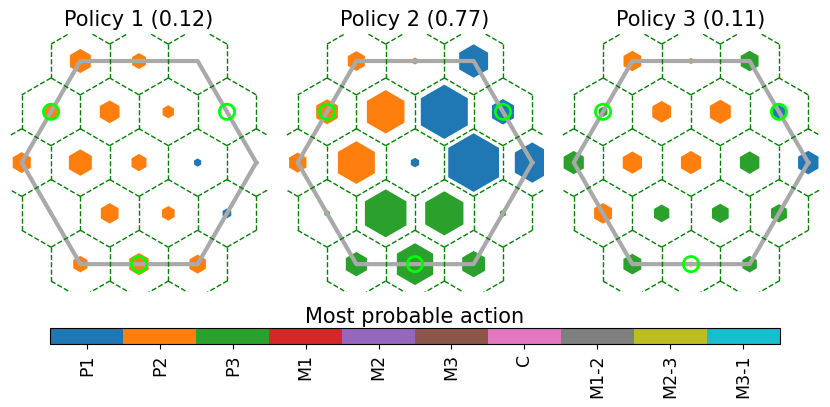

In [35]:
num_tiles = env.arena.num_tiles
probs = np.empty((num_policies, num_tiles, num_macros))
for k in range(num_policies):
    for pos in range(num_tiles):
        idxs = knowns[:, 0].numpy().astype(int)==pos
        probs[k, pos] = logps[idxs, k].exp().mean(dim=0).numpy()
probs[..., 3:] = 0.

fig = plt.figure(figsize=(3*num_policies, 4))
margin, gap = 0.05, 0.02
width = (1-2*margin-2*gap)/num_policies
axes = []
for k in range(num_policies):
    ax = fig.add_axes([margin+(width+gap)*k, 0.05, width, 0.9])
    env.arena.plot_mesh(ax)
    for pos in range(num_tiles):
        a_idx = np.argmax(probs[k, pos])
        # color = (*palette[a_idx], probs[k, pos, a_idx])
        env.arena.plot_tile(ax, pos, color=palette[a_idx], size=probs[k, pos, a_idx]/probs.max())
    ax.set_title('Policy {} ({:.2f})'.format(k+1, gammas[k]), fontsize='medium')
    axes.append(ax)
cbar = plt.colorbar(
    mpl.cm.ScalarMappable(cmap='tab10'), ax=axes,
    orientation='horizontal', shrink=.9, aspect=15*num_policies, pad=0.1,
    label='Most probable action',
)
cbar.ax.set_xticks((np.arange(num_macros)+0.5)/num_macros)
cbar.ax.set_xticklabels([
    'P1', 'P2', 'P3', 'M1', 'M2', 'M3', 'C', 'M1-2', 'M2-3', 'M3-1',
], rotation=90)
cbar.ax.xaxis.set_label_position('top')
plt.show()